**Introduction to physics based learning**  
ATAL-AICTE Workshop on Multidisciplinary Design Optimization  
Dec 9, 2021.


**Amuthan A. Ramabathiran**  
Dept. of Aerospace Engineering  
IIT Bombay

*E-mail:* amuthan \_at\_ aero.iitb.ac.in  
*Webpage:* https://amuthan.github.io/webpage/

**0. Introduction**

The basic idea in physics based learning is to endow ML algorithms with known physical laws for the particular application under scrutiny. This notebook provides an elementary introduction to *physics based learning*.

*Note:* This notebook does not have a lot of written explanations; please watch the workshop video for more details. (Link coming up soon!)

**1. Automatic Differentiation with PyTorch**

In [ ]:
import numpy
from matplotlib import pyplot
import torch

In [ ]:
xt = torch.tensor(1.5, dtype=torch.float32, requires_grad=True)

def f(x):
  return x*x*torch.sin(x)

def dfdx(x):
  return 2*x*torch.sin(x) + x*x*torch.cos(x)

yt = f(xt)
dydt = dfdx(xt)
print(f'y = {yt:.4f}, dydx = {dydt:.4f}')

y = 2.2444, dydx = 3.1516


In [ ]:
yt.backward()
print(f'dydt (AD) = {xt.grad:.4f}')

dydt (AD) = 3.1516


In [ ]:
def g(x):
  return x*x

def dgdx(x):
  return 2*x

zt = g(xt)
dzdx = dgdx(xt)
print(f'z = {zt:.4f}, dzdx = {dzdx:.4f}')

z = 2.2500, dzdx = 3.0000


In [ ]:
zt.backward()
print(f'dzdt (AD; incorrect!) = {xt.grad:.4f}')

dzdt (AD; incorrect!) = 6.1516


Make sure you set the gradient to `None` explicitly before you perform a fresh computation!

In [ ]:
xt.grad = None
zt = g(xt)
zt.backward()
print(f'dzdx (AD; correct!) = {xt.grad:.4f}')

dzdx (AD; correct!) = 3.0000


**2. Supervised vs physics-based learning**

A very simple example illustrating the difference between supervised and physics-based learning, adapted from http://physicsbaseddeeplearning.org/intro-teaser.html.

**2.1 Generate data**

Text(0, 0.5, 'y')

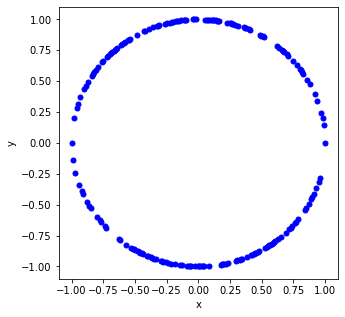

In [ ]:
def generate_circle_data(n_data):
  xs = numpy.linspace(-1.0, 1.0, n_data)
  ys = numpy.sqrt(1 - xs*xs)

  for i in range(n_data):
    if numpy.random.random() < 0.5:
      ys[i] *= -1.0

  return xs, ys

n_data = 200
xs, ys = generate_circle_data(n_data)

pyplot.figure(figsize=(5,5))
pyplot.plot(xs, ys, 'bo', markersize=5)
pyplot.xlabel('x')
pyplot.ylabel('y')

PyTorch provides nice wrappers to handle data. We will use the `Dataset` and `DataLoader` classes from `torch.utils.data`.

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SLdata(Dataset):
  def __init__(self, xs, ys):
    self.xs = torch.tensor(xs, dtype=torch.float32).unsqueeze(1)
    self.ys = torch.tensor(ys, dtype=torch.float32).unsqueeze(1)

  def __len__(self):
    return len(self.ys)

  def __getitem__(self, idx):
    x = self.xs[idx]
    y = self.ys[idx]
    return x, y

data_circ = SLdata(xs, ys)

batch = 25
dl_circ = DataLoader(data_circ, batch_size=batch, shuffle=True)

for xb, yb in dl_circ:
  print(xb)
  print(yb)
  break

tensor([[ 0.5477],
        [ 0.4472],
        [ 0.0050],
        [-0.5477],
        [-0.1357],
        [ 0.9799],
        [-0.6884],
        [-0.9196],
        [ 0.8090],
        [-0.5578],
        [-0.7487],
        [ 0.3467],
        [-0.0955],
        [ 0.4573],
        [-0.5276],
        [ 0.1357],
        [ 0.9296],
        [ 0.2161],
        [ 0.4372],
        [ 0.5879],
        [-0.8291],
        [-0.6583],
        [ 0.2864],
        [ 0.7588],
        [-0.9296]])
tensor([[-0.8366],
        [-0.8944],
        [-1.0000],
        [ 0.8366],
        [ 0.9908],
        [ 0.1995],
        [ 0.7253],
        [-0.3929],
        [ 0.5877],
        [ 0.8300],
        [ 0.6629],
        [-0.9380],
        [ 0.9954],
        [-0.8893],
        [-0.8495],
        [ 0.9908],
        [-0.3684],
        [-0.9764],
        [-0.8994],
        [-0.8089],
        [ 0.5590],
        [ 0.7528],
        [ 0.9581],
        [-0.6513],
        [ 0.3684]])


**2.2 Supervised learning**

Set up neural network.

In [ ]:
class CircleNet(torch.nn.Module):
  def __init__(self, n_hidden=10):
    super(CircleNet, self).__init__()
    self.n_hidden = n_hidden
    self.layer1 = torch.nn.Linear(1, n_hidden)
    self.layer2 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer3 = torch.nn.Linear(n_hidden, 1)

  def forward(self, x):
    x = self.layer1(x)
    x = torch.tanh(x)
    x = self.layer2(x)
    x = torch.tanh(x)
    x = self.layer3(x)
    return x

n_hidden = 20
dnn_SL = CircleNet(n_hidden=n_hidden)

dnn_SL(data_circ[0][0])

tensor([-0.0844], grad_fn=<AddBackward0>)

Train DNN.

Epoch 0/100: loss = 0.687977634370327
Epoch 1/100: loss = 0.6843412816524506
Epoch 2/100: loss = 0.68118055164814
Epoch 3/100: loss = 0.6782512664794922
Epoch 4/100: loss = 0.6759220138192177
Epoch 5/100: loss = 0.6737289130687714
Epoch 6/100: loss = 0.6721459925174713
Epoch 7/100: loss = 0.6704582273960114
Epoch 8/100: loss = 0.6689333543181419
Epoch 9/100: loss = 0.6677174493670464
Epoch 10/100: loss = 0.6667450293898582
Epoch 11/100: loss = 0.6660370975732803
Epoch 12/100: loss = 0.6651051491498947
Epoch 13/100: loss = 0.6644870564341545
Epoch 14/100: loss = 0.6637968122959137
Epoch 15/100: loss = 0.6636263802647591
Epoch 16/100: loss = 0.6630069017410278
Epoch 17/100: loss = 0.6625455766916275
Epoch 18/100: loss = 0.66236911714077
Epoch 19/100: loss = 0.6618903055787086
Epoch 20/100: loss = 0.6618309691548347
Epoch 21/100: loss = 0.6617535427212715
Epoch 22/100: loss = 0.6615872532129288
Epoch 23/100: loss = 0.6612879857420921
Epoch 24/100: loss = 0.6611828804016113
Epoch 25/100: l

Text(0, 0.5, 'Training loss')

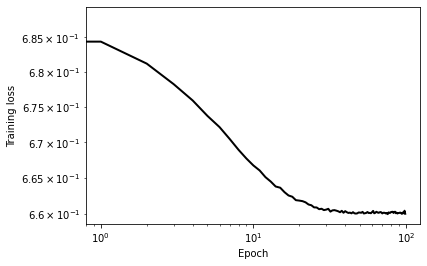

In [ ]:
def train_SL(model, loss_fn, optimizer, dl):
  train_loss = 0.0
  for xb, yb in dl:
    optimizer.zero_grad()
    ypred = model(xb)
    loss = loss_fn(ypred, yb)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(dl)
  return train_loss

epochs = 100
lr = 1e-3
optimizer = torch.optim.SGD(dnn_SL.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

losses = []
for epoch in range(epochs):
  loss = train_SL(dnn_SL, loss_fn, optimizer, dl_circ)
  losses.append(loss)
  print(f'Epoch {epoch}/{epochs}: loss = {loss}')

pyplot.loglog(losses, 'k-', linewidth=2)
pyplot.xlabel('Epoch')
pyplot.ylabel('Training loss')

Test DNN.

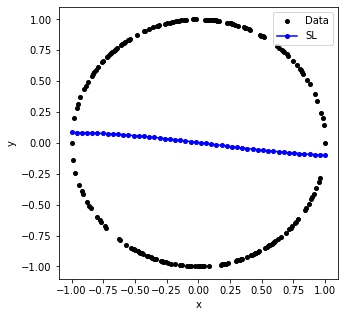

In [ ]:
n_test = 50
xs_test = torch.linspace(-1.0, 1.0, n_test, dtype=torch.float32).unsqueeze(1)
ys_SL = dnn_SL(xs_test)

xp = xs_test.squeeze().detach().cpu().numpy()
yp_SL = ys_SL.squeeze().detach().cpu().numpy()

pyplot.figure(figsize=(5,5))
pyplot.plot(xs, ys, 'ko', markersize=4, label='Data')
pyplot.plot(xp, yp_SL, 'bo-', markersize=4, label='SL')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.legend()

**2.3 Differentiable Physics**

Generate data.

In [ ]:
class DPdata(Dataset):
  def __init__(self, xs):
    self.xs = torch.tensor(xs, dtype=torch.float32).unsqueeze(1)

  def __len__(self):
    return len(self.xs)

  def __getitem__(self, idx):
    x = self.xs[idx]
    return x

data_DP = DPdata(xs)

batch = 25
dl_DP = DataLoader(data_DP, batch_size=batch, shuffle=True)

Set up DNN.

In [ ]:
n_hidden = 20
dnn_DP = CircleNet(n_hidden=n_hidden)

Define loss function for DP.

In [ ]:
def _physics(x, y):
  return (x*x + y*y - 1.0)

def loss_DP(model, xb):
  yb = model(xb)
  res = _physics(xb, yb)**2
  return torch.mean(res)

Train DNN.

Epoch 0/1000: loss = 0.2662077844142914
Epoch 100/1000: loss = 0.029039125656709075
Epoch 200/1000: loss = 0.009834202064666897
Epoch 300/1000: loss = 0.004556072526611388
Epoch 400/1000: loss = 0.003723343528690748
Epoch 500/1000: loss = 0.003517616249155253
Epoch 600/1000: loss = 0.0033992771641351283
Epoch 700/1000: loss = 0.0032977099472191185
Epoch 800/1000: loss = 0.003211451694369316
Epoch 900/1000: loss = 0.0031272058695321903


Text(0, 0.5, 'Training loss')

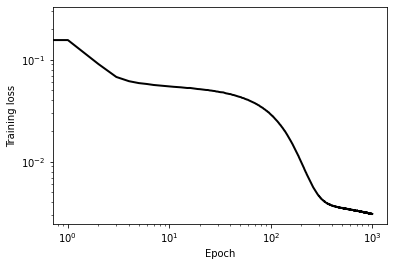

In [ ]:
def train_DP(model, loss_fn, optimizer, dl):
  train_loss = 0.0
  for xb in dl:
    optimizer.zero_grad()
    loss = loss_fn(model, xb)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(dl)
  return train_loss

epochs = 1000
lr = 5e-3
optimizer = torch.optim.SGD(dnn_DP.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
  loss = train_DP(dnn_DP, loss_DP, optimizer, dl_DP)
  losses.append(loss)
  if epoch%100 == 0:
    print(f'Epoch {epoch}/{epochs}: loss = {loss}')

pyplot.loglog(losses, 'k-', linewidth=2)
pyplot.xlabel('Epoch')
pyplot.ylabel('Training loss')

Test DNN.

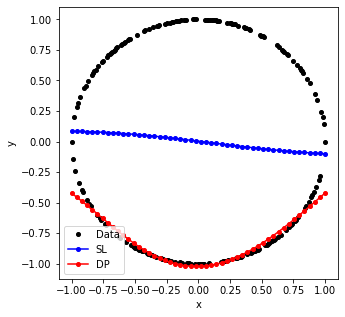

In [ ]:
ys_DP = dnn_DP(xs_test)
yp_DP = ys_DP.squeeze().detach().cpu().numpy()

pyplot.figure(figsize=(5,5))
pyplot.plot(xs, ys, 'ko', markersize=4, label='Data')
pyplot.plot(xp, yp_SL, 'bo-', markersize=4, label='SL')
pyplot.plot(xp, yp_DP, 'ro-', markersize=4, label='DP')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.legend()

**3. Solving ODEs with DNN**

Consider the simple ODE

$$
\frac{dx(t)}{dt} = 2\pi \cos (2\pi t), \quad x(0) = 1.
$$

The exact solution to this ODE is

$$
x(t) = 1 + \sin (2\pi t).
$$

This is now solved using both finite difference and DNN approximations.

**3.1 Forward Euler method**

The forward Euler finite difference scheme for this ODE takes the following iterative form: 

$$
x_{n+1} = x_n + 2\pi \Delta t \cos (2 \pi t_n), \quad n \ge 0. 
$$

We will solve this over the intervar $[0,1]$.

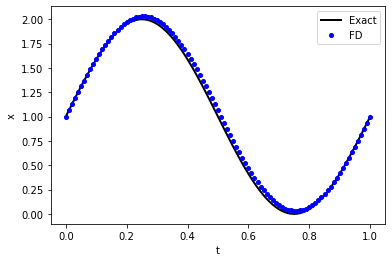

In [ ]:
t0 = 0.0
tf = 1.0
dt = 0.01
nt = int((tf - t0)/dt)

x0 = 1.0
pi = numpy.pi

def f_ODE(t):
  return 2*pi*numpy.cos(2*pi*t)

def x_exact(t):
  return 1 + numpy.sin(2*pi*t)

def forward_Euler(x0, t0, dt, nt):
  xs = [x0]
  for i in range(nt):
    t = t0 + i*dt
    xn = xs[-1]
    x = xn + dt*f_ODE(t)
    xs.append(x)
  return xs

xs = forward_Euler(x0, t0, dt, nt)
ts = numpy.linspace(t0, tf, (nt + 1))
xs_exact = x_exact(ts)

pyplot.plot(ts, xs_exact, 'k-', linewidth=2, label='Exact')
pyplot.plot(ts, xs, 'bo', markersize=4, label='FD')
pyplot.xlabel('t')
pyplot.ylabel('x')
pyplot.legend()

**3.2 DNN**

We will approximate the solution $x(t)$ by a DNN $\hat{x}(t; \theta)$, and enforce the boundary condition $\hat{x}(0; \theta) = 1$ using the penalty method.

The approach is similar to what we had earlier, except that the derivative $d\hat{x}(t; \theta)/dt$ is computed using finite differences.

Epoch 0/1000: loss = 28.630006472269695
Epoch 100/1000: loss = 20.202211062113445
Epoch 200/1000: loss = 2.0710405309995017
Epoch 300/1000: loss = 0.82246266802152
Epoch 400/1000: loss = 0.29337412615617114
Epoch 500/1000: loss = 0.09770817061265309
Epoch 600/1000: loss = 0.056608482574423157
Epoch 700/1000: loss = 0.03376182807066167
Epoch 800/1000: loss = 0.03586140771706899
Epoch 900/1000: loss = 0.026769544929265976


Text(0, 0.5, 'Training loss')

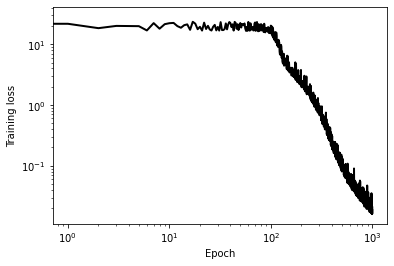

In [ ]:
class ODEdata(Dataset):
  def __init__(self, ts):
    self.ts = torch.tensor(ts, dtype=torch.float32).unsqueeze(1)

  def __len__(self):
    return len(self.ts)

  def __getitem__(self, idx):
    t = self.ts[idx]
    return t

class ODENet(torch.nn.Module):
  def __init__(self, n_hidden=10):
    super(ODENet, self).__init__()
    self.n_hidden = n_hidden
    self.layer1 = torch.nn.Linear(1, n_hidden)
    self.layer2 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer3 = torch.nn.Linear(n_hidden, 1)

  def forward(self, t):
    x = self.layer1(t)
    x = torch.tanh(x)
    x = self.layer2(x)
    x = torch.tanh(x)
    x = self.layer3(x)
    return x

def _ode(t, x, xt):
  return xt - 2*pi*torch.cos(2*pi*t)

def loss_ODE(model, tb, h, t0, x0, wt):
  xb = model(tb)
  xbt = (model(tb + h) - xb)/h 
  ode = _ode(tb, xb, xbt)
  res_int = torch.mean(ode**2)
  res_bdy = (model(torch.tensor([t0], dtype=torch.float32)) - x0)**2
  res = res_int + wt*res_bdy
  return res

def train_ODE(model, optimizer, dl, 
              h=1e-4, t0=0.0, x0=0.0, wt=1.0):
  train_loss = 0.0
  for tb in dl:
    optimizer.zero_grad()
    loss = loss_ODE(model, tb, h, t0, x0, wt)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(dl)
  return train_loss

data_ode = ODEdata(ts)
batch = 20
dl_ode = DataLoader(data_ode, batch_size=batch, shuffle=True)

n_hidden = 20
dnn_ode = ODENet(n_hidden=n_hidden)

epochs = 1000
lr = 1e-3
optimizer = torch.optim.SGD(dnn_ode.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
  loss = train_ODE(dnn_ode, optimizer, dl_ode, x0=1.0, wt=10.0)
  losses.append(loss)
  if epoch%100 == 0:
    print(f'Epoch {epoch}/{epochs}: loss = {loss}')

pyplot.loglog(losses, 'k-', linewidth=2)
pyplot.xlabel('Epoch')
pyplot.ylabel('Training loss')

Test DNN solution.

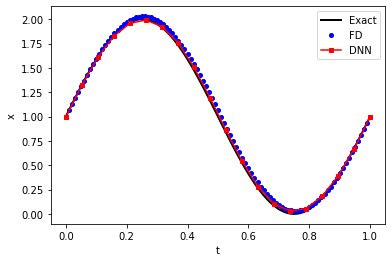

In [ ]:
n_test = 20
ts_test = numpy.linspace(t0, tf, n_test)
tp = torch.tensor(ts_test, dtype=torch.float32).unsqueeze(1)
xs_dnn = dnn_ode(tp)
xp = xs_dnn.squeeze().detach().cpu().numpy()

pyplot.plot(ts, xs_exact, 'k-', linewidth=2, label='Exact')
pyplot.plot(ts, xs, 'bo', markersize=4, label='FD')
pyplot.plot(tp, xp, 'rs-', markersize=4, label='DNN')
pyplot.xlabel('t')
pyplot.ylabel('x')
pyplot.legend()

**4. Inverse problem: simulation of cricket ball trajectory**

**4.1 Trajectory simulation**

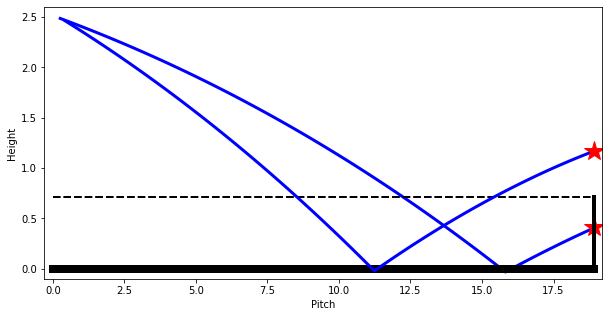

In [ ]:
g = 9.81 # m/s^2
m = 0.16 # kg
r = 0.036 # m
A = pi*r*r # m^2
rho = 1.225 # kg/m^3
C = 0.5*rho*A/m # 1/m
Cd = 0.5 # nondim

L = 20.12 - 1.22 # m; pitch length - crease length
H = 2.5 # m; maximum height of release
S = 0.71 # m; stumps height

deg2rad = pi/180.0
kmph2mps = 0.277778

def get_position(release):
  xs = torch.zeros(2, dtype=torch.float32)
  xs[0] = H*torch.sin(release)
  xs[1] = H*torch.cos(release)
  return xs

def get_velocity(release, speed):
  vs = torch.zeros(2, dtype=torch.float32)
  vs[0] = speed*torch.cos(release)
  vs[1] = -speed*torch.sin(release)
  return vs

def f_traj(u, v, windspeed):
  fs = torch.zeros(2)
  v_norm = torch.sqrt((u - windspeed)**2 + v**2)
  fs[0] = -v_norm*C*Cd*(u - windspeed)
  fs[1] = -v_norm*C*Cd*v - g
  return fs 

# This is a symplectic Euler scheme!
def step_Euler(xs, vs, windspeed, dt):
  vs = vs + dt*f_traj(*vs, windspeed)
  xs = xs + dt*vs
  return xs, vs

def wicket(x, y):
  if abs(x - L) < 0.075 and y >= 0.0 and y <= S:
    return True
  else:
    return False

def bowl(xs, vs, windspeed, bounce, dt, 
         max_itr=1000, history=False):
  itr = 0
  traj = []
  if history:
    traj.append(xs)
  first_bounce = True
  
  while xs[0] <= L and itr <= max_itr:
    itr += 1
    xs, vs = step_Euler(xs, vs, windspeed, dt)
    if xs[1] <= 0.0 and first_bounce:
      vs[1] = -bounce*vs[1]
      first_bounce = False
    if history:
      traj.append(xs)

  if history:
    return traj
  else:
    return xs

def plot_trajectory(traj):
  xs = []
  ys = []
  for xy in traj:
    xs.append(xy[0].item())
    ys.append(xy[1].item())

  pyplot.plot([0,L],[0,0], 'k-', linewidth=8)
  pyplot.plot([0,L],[S,S], 'k--', linewidth=2)
  pyplot.plot([L,L], [0,S], 'k-', linewidth=4)
  pyplot.plot(xs, ys, 'b-', linewidth=3)
  pyplot.plot([L], [ys[-1]], 'r*', markersize=20)
  pyplot.xlabel('Pitch')
  pyplot.ylabel('Height')
  pyplot.xlim((-0.3, L + 0.3))
  pyplot.ylim((-0.1, H + 0.1))

# Example of a trajectory
speed = 140*kmph2mps
release = 6*deg2rad
windspeed = -4.0*kmph2mps
bounce = 0.7

xs = get_position(torch.tensor(release, dtype=torch.float32))
vs = get_velocity(torch.tensor(release, dtype=torch.float32),
                  torch.tensor(speed, dtype=torch.float32))

dt = 0.005 # s
traj = bowl(xs, vs, windspeed, bounce, dt, history=True)

pyplot.figure(figsize=(10,5))
plot_trajectory(traj)

speed = 120*kmph2mps
release = 10*deg2rad
windspeed = -4.0*kmph2mps
bounce = 0.7

xs = get_position(torch.tensor(release, dtype=torch.float32))
vs = get_velocity(torch.tensor(release, dtype=torch.float32),
                  torch.tensor(speed, dtype=torch.float32))

dt = 0.005 # s
traj = bowl(xs, vs, windspeed, bounce, dt, history=True)

plot_trajectory(traj)

**4.2 Inverse problem - learning to bowl!**

In [ ]:
def sigmoid(x, a=2.0):
  return 1.0/(1.0 + torch.exp(-a*x))

# Input: windspeed, pitch bounce
# Output: release angle, speed
class Bowl(torch.nn.Module):
  def __init__(self, n_hidden=10, scale=1.0):
    super(Bowl, self).__init__()
    self.n_hidden = n_hidden
    self.scale = scale
    self.layer1 = torch.nn.Linear(2, n_hidden)
    self.layer2 = torch.nn.Linear(n_hidden, n_hidden)
    self.layer3 = torch.nn.Linear(n_hidden, 2)
    self.act = torch.nn.ReLU()

  def forward(self, x):
    x = self.layer1(x)
    x = self.act(x)
    x = self.layer2(x)
    x = self.act(x)
    x = self.layer3(x)
    x = sigmoid(x, self.scale) # To scale output to [0,1]
    return x

xs_wicket = torch.tensor(
    [L, 0.75*S], dtype=torch.float32
)
speed_lo = 100*kmph2mps
speed_hi = 160*kmph2mps
release_lo = 0.0*deg2rad
release_hi = 10.0*deg2rad

def loss_bowl(model, windspeed, bounce, dt):
  wb = torch.tensor(
      [windspeed, bounce], dtype=torch.float32, requires_grad=True
  )
  rs = model(wb)
  release = release_lo + (release_hi - release_lo)*rs[0]
  speed = speed_lo + (speed_hi - speed_lo)*rs[1]
  xs = get_position(release)
  vs = get_velocity(release, speed)
  xs = bowl(xs, vs, windspeed, bounce, dt)
  loss = 0.5*torch.norm(xs - xs_wicket)**2
  return loss 

def train_bowl(model, optimizer, windspeeds, bounces, dt):
  train_loss = 0.0
  for w, b in zip(windspeeds, bounces):
    optimizer.zero_grad()
    loss = loss_bowl(model, w, b, dt)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(windspeeds)
  return train_loss

Training DNN.

Epoch 0/50: loss = 0.0017068564794802418
Epoch 1/50: loss = 0.0017166753280131767
Epoch 2/50: loss = 0.0017119800555519759
Epoch 3/50: loss = 0.0017072931436511378
Epoch 4/50: loss = 0.0017026199415947
Epoch 5/50: loss = 0.0016980606170060733
Epoch 6/50: loss = 0.0016933699080254883
Epoch 7/50: loss = 0.001688737429988881
Epoch 8/50: loss = 0.00168417693542627
Epoch 9/50: loss = 0.001679652122159799
Epoch 10/50: loss = 0.0016751055838540197
Epoch 11/50: loss = 0.0016705504812610647
Epoch 12/50: loss = 0.0016660487182283154
Epoch 13/50: loss = 0.0016615138350365062
Epoch 14/50: loss = 0.0016569404241939386
Epoch 15/50: loss = 0.0016524977807421237
Epoch 16/50: loss = 0.0016479987689914802
Epoch 17/50: loss = 0.0016435127200869223
Epoch 18/50: loss = 0.0016390166827477514
Epoch 19/50: loss = 0.0016345919963593285
Epoch 20/50: loss = 0.0016301998247702917
Epoch 21/50: loss = 0.0016257406678050756
Epoch 22/50: loss = 0.0016212991904467344
Epoch 23/50: loss = 0.0016169046284630895
Epoch 24/

Text(0, 0.5, 'Training loss')

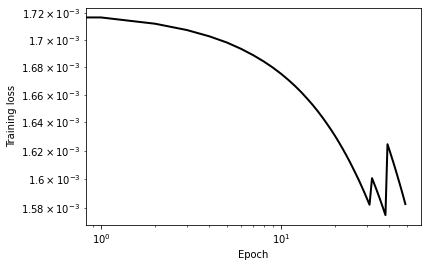

In [ ]:
n_bowl = 30
max_windspeed = 2.0*kmph2mps
bounce_lo = 0.9
bounce_spread = 0.1
windspeeds = (2*numpy.random.random(n_bowl) - 1)*max_windspeed 
bounces = bounce_lo + numpy.random.random(n_bowl)*bounce_spread

n_hidden = 10
scale = 0.5
dnn_bowl = Bowl(n_hidden=n_hidden, scale=scale)

epochs = 50
lr = 1e-6
optimizer = torch.optim.Adam(dnn_bowl.parameters(), lr=lr) #, 
                            # momentum=0.9)

dt = 0.002 # s

losses = []
for epoch in range(epochs):
  loss = train_bowl(dnn_bowl, optimizer, windspeeds, bounces, dt)
  losses.append(loss)
  print(f'Epoch {epoch}/{epochs}: loss = {loss}')

pyplot.loglog(losses, 'k-', linewidth=2)
pyplot.xlabel('Epoch')
pyplot.ylabel('Training loss')

Training accuracy and performance of trained DNN on training conditions.

Train 0/30: Release angle = 4.855368137359619, Speed = 128.8042449951172 kmph
Train 0/30: Wicket!
Train 1/30: Release angle = 4.831226825714111, Speed = 128.44325256347656 kmph
Train 1/30: Wicket!
Train 2/30: Release angle = 4.8565778732299805, Speed = 128.90176391601562 kmph
Train 2/30: Wicket!
Train 3/30: Release angle = 4.854795932769775, Speed = 128.9524383544922 kmph
Train 3/30: Wicket!
Train 4/30: Release angle = 4.84805965423584, Speed = 128.67037963867188 kmph
Train 4/30: Wicket!
Train 5/30: Release angle = 4.855868339538574, Speed = 128.81716918945312 kmph
Train 5/30: Wicket!
Train 6/30: Release angle = 4.8552141189575195, Speed = 128.945556640625 kmph
Train 6/30: Wicket!
Train 7/30: Release angle = 4.85322904586792, Speed = 128.7724609375 kmph
Train 7/30: Wicket!
Train 8/30: Release angle = 4.853551864624023, Speed = 129.01451110839844 kmph
Train 8/30: Wicket!
Train 9/30: Release angle = 4.855844974517822, Speed = 128.935302734375 kmph
Train 9/30: Wicket!
Train 10/30: Release

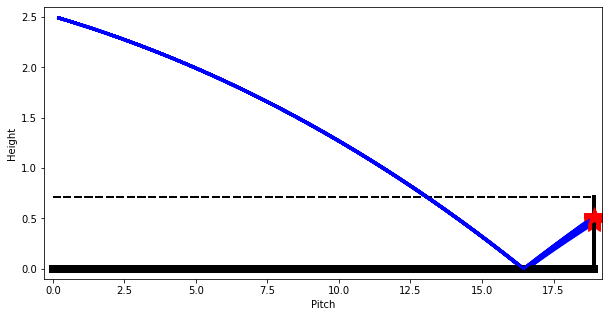

In [ ]:
accuracy = 0.0

pyplot.figure(figsize=(10,5))
for i in range(n_bowl):
  rs = dnn_bowl(torch.tensor(
      [windspeeds[i], bounces[i]], dtype=torch.float32
  ))
  release = release_lo + (release_hi - release_lo)*rs[0]
  speed = speed_lo + (speed_hi - speed_lo)*rs[1]
  print(f'Train {i}/{n_bowl}: Release angle = {release/deg2rad}, ' \
        f'Speed = {speed/kmph2mps} kmph')
  xs = get_position(release)
  vs = get_velocity(release, speed)

  traj = bowl(xs, vs, windspeeds[i], bounces[i], dt, history=True)
  plot_trajectory(traj)

  xs = traj[-1]
  if wicket(xs[0], xs[1]):
    print(f'Train {i}/{n_bowl}: Wicket!')
    accuracy += 1
  else:
    print(f'Train {i}/{n_bowl}: Miss!')

accuracy /= n_bowl
print(f'Bowling accuracy (train) = {accuracy}')

Test DNN.

Test 0/30: Release angle = 4.622374057769775, Speed = 130.31414794921875 kmph
Test 0/30: Wicket!
Test 1/30: Release angle = 4.825640678405762, Speed = 128.37364196777344 kmph
Test 1/30: Wicket!
Test 2/30: Release angle = 4.765450954437256, Speed = 129.64376831054688 kmph
Test 2/30: Wicket!
Test 3/30: Release angle = 4.823487281799316, Speed = 128.3441162109375 kmph
Test 3/30: Wicket!
Test 4/30: Release angle = 4.580990314483643, Speed = 130.55191040039062 kmph
Test 4/30: Wicket!
Test 5/30: Release angle = 4.7612528800964355, Speed = 129.66445922851562 kmph
Test 5/30: Wicket!
Test 6/30: Release angle = 4.830195426940918, Speed = 128.48016357421875 kmph
Test 6/30: Wicket!
Test 7/30: Release angle = 4.493997573852539, Speed = 127.05663299560547 kmph
Test 7/30: Wicket!
Test 8/30: Release angle = 4.590732574462891, Speed = 130.5242919921875 kmph
Test 8/30: Wicket!
Test 9/30: Release angle = 4.611622333526611, Speed = 130.4056396484375 kmph
Test 9/30: Wicket!
Test 10/30: Release angle = 4.63

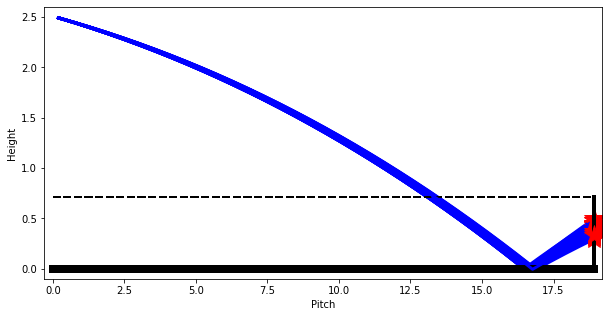

In [ ]:
n_test = 30
max_windspeed = 10.0*kmph2mps
bounce_lo = 0.7
bounce_spread = 0.3
ws_test = (2*numpy.random.random(n_test) - 1)*max_windspeed
b_test = bounce_lo + numpy.random.random(n_test)*bounce_spread
accuracy = 0.0

pyplot.figure(figsize=(10,5))
for i in range(n_test):
  rs = dnn_bowl(torch.tensor(
      [ws_test[i], b_test[i]], dtype=torch.float32
  ))
  release = release_lo + (release_hi - release_lo)*rs[0]
  speed = speed_lo + (speed_hi - speed_lo)*rs[1]
  print(f'Test {i}/{n_test}: Release angle = {release/deg2rad}, ' \
        f'Speed = {speed/kmph2mps} kmph')
  xs = get_position(release)
  vs = get_velocity(release, speed)

  traj = bowl(xs, vs, ws_test[i], b_test[i], dt, history=True)
  plot_trajectory(traj)

  xs = traj[-1]
  if wicket(xs[0], xs[1]):
    print(f'Test {i}/{n_test}: Wicket!')
    accuracy += 1
  else:
    print(f'Test {i}/{n_test}: Miss!')

accuracy /= n_test
print(f'Bowling accuracy = {accuracy}')